# Clustering ETFs

This projected is being developed as part of a master thesis for the degree of Electrical and Computer Engineering.

## Dependencies

This notebook requires code from:
    
- `class_SeriesAnalyser.py` - contains a set of functions to deal with time series analysis.
- `class_Trader.py` - contains a set of functions concerning trading strategies.
- `class_DataProcessor.py` - contains a set of functions concerning the data pre processing.

As a good practise, the notebook solely intends to exemplify the application of different trading strategies for different dataset examples, rather than coding the strategies theirselves. Please look into the files menitoned above for more detailed info on how the functions are built.

## Table of Contents
    
    1. Commodity ETFs - entire workflow application example

### Import Libraries

In [2]:
import numpy as np
np.random.seed(1) # NumPy
import random
random.seed(3) # Python
import tensorflow as tf
tf.set_random_seed(2) # Tensorflow
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

/Users/simaomoraessarmento/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
import pandas as pd
import pickle

import json

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Import Datetime and the Pandas DataReader
from datetime import datetime
from pandas_datareader import data, wb

# Import alpha vantage
from alpha_vantage.timeseries import TimeSeries

# Import scikit instruments
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing
from sklearn.metrics import silhouette_score
from sklearn.metrics import mean_squared_error

# Import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Dropout
from keras.optimizers import SGD, Adam
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.callbacks import EarlyStopping

/Users/simaomoraessarmento/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
config_file = 'config/config_commodities_2010_2019.json'

### Import Configurations

In [5]:
with open(config_file, 'r') as f:
    config = json.load(f)

### Import Classes

In [6]:
%load_ext autoreload
%aimport class_SeriesAnalyser, class_Trader, class_DataProcessor, class_ForecastingTrader
%autoreload 1

In [7]:
series_analyser = class_SeriesAnalyser.SeriesAnalyser()
trader = class_Trader.Trader()
data_processor = class_DataProcessor.DataProcessor()
forecasting_trader = class_ForecastingTrader.ForecastingTrader()

# 1. Commodity ETFs Dataset

In this section, we proceed to analyze ETFs from different commodity sectors and detect possible interesting pairs. The process goes as follows:

- Upload time series corresponding to ETFs
- Apply dimensionality reduction and cluster securities
- Run cointegration tests for securities within the same cluster

We start by retrieving the data from a Dataframe saved in a pickle file, as it was previously processed in the `PairsTrading_CommodityETFS_Datapreprocessing.ipynb` notebook.

In [8]:
df_prices = pd.read_pickle('data/etfs/pickle/commodity_ETFs_long_updated')

In [9]:
# split data in training and test
df_prices_train, df_prices_test = data_processor.split_data(df_prices,
                                                            (config['dataset']['training_initial_date'],
                                                             config['dataset']['training_final_date']),
                                                            (config['dataset']['testing_initial_date'],
                                                             config['dataset']['testing_final_date']),
                                                            remove_nan=True)

Total of 208 tickers
Total of 77 tickers after removing tickers with Nan values


In [10]:
# split data in training and test
df_prices_train, df_prices_test = data_processor.split_data(df_prices,
                                                            ('01-01-2010',
                                                             '31-12-2017'),
                                                            ('01-01-2018',
                                                             '31-12-2018'),
                                                            remove_nan=True)

Total of 208 tickers
Total of 77 tickers after removing tickers with Nan values


In [11]:
len(df_prices_train)+len(df_prices_test)

2264

# 1. No Clustering

In [12]:
no_cluster_series = pd.Series(0,index = df_prices_train.columns)
pairs_all_a_all, unique_tickers = series_analyser.get_candidate_pairs(clustered_series=no_cluster_series,
                                                            pricing_df_train=df_prices_train,
                                                            pricing_df_test=df_prices_test,
                                                            min_half_life=config['pair_restrictions']['min_half_life'],
                                                            min_zero_crosings=config['pair_restrictions']['min_zero_crossings'],
                                                            p_value_threshold=config['pair_restrictions']['p_value_threshold'],
                                                            hurst_threshold=config['pair_restrictions']['hurst_threshold']
                                                            )
pairs_found_all_a_all = len(pairs_all_a_all)
print('Found {} pairs'.format(pairs_found_all_a_all))

Found 569 pairs
The pairs contain 77 unique tickers
Found 569 pairs


In [14]:
print('Out of {} possible combinations'.format(len(df_prices_train.columns)*(len(df_prices_train.columns)-1)/2))

Out of 2926.0 possible combinations


# 2. Clustering by Category

In [12]:
segment_mapper = {
                'Commodities: Agriculture':'Agriculture',
                'Commodities: Agriculture Cocoa':'Agriculture',
                'Commodities: Agriculture Coffee':'Agriculture',
                'Commodities: Agriculture Corn':'Agriculture',
                'Commodities: Agriculture Cotton':'Agriculture',
                'Commodities: Agriculture Grains':'Agriculture',
                'Commodities: Agriculture Livestock':'Agriculture',
                'Commodities: Agriculture Softs':'Agriculture',
                'Commodities: Agriculture Soybeans':'Agriculture',
                'Commodities: Agriculture Sugar':'Agriculture',
                'Commodities: Agriculture Wheat':'Agriculture',
                'Equity: Global Water':'Agriculture',
                'Commodities: Broad Market':'Broad Market',
                'Commodities: Broad Market Metals':'Broad Market',
                'Commodities: Energy':'Energy',
                'Commodities: Energy Crude Oil':'Energy',
                'Commodities: Energy Gasoline':'Energy',
                'Commodities: Energy Natural Gas':'Energy',
                'Inverse Commodities: Energy Crude Oil':'Energy',
                'Inverse Commodities: Energy Natural Gas':'Energy',
                'Leveraged Commodities: Energy Crude Oil':'Energy',
                'Leveraged Commodities: Energy Natural Gas':'Energy',
                'Equity: U.S. MLPs':'Energy',
                'Equity: U.S. Energy':'Energy',
                'Inverse Equity: U.S. Energy':'Energy',
                'Equity: U.S. Oil & Gas Exploration & Production':'Energy',
                'Equity: U.S. Oil & Gas Equipment & Services':'Energy',
                'Equity: Global Energy':'Energy',
                'Equity: Global Nuclear Energy':'Energy',
                'Equity: Global Oil & Gas Equipment & Services':'Energy',
                'Equity: U.S. Natural Gas':'Energy',
                'Equity: Global Coal':'Energy',
                'Leveraged Equity: U.S. Energy':'Energy',
                'Commodities: Industrial Metals':'Industrial Metals',
                'Commodities: Industrial Metals Aluminum':'Industrial Metals',
                'Commodities: Industrial Metals Copper':'Industrial Metals',
                'Commodities: Industrial Metals Lead':'Industrial Metals',
                'Commodities: Industrial Metals Nickel':'Industrial Metals',
                'Commodities: Industrial Metals Tin':'Industrial Metals',
                'Equity: U.S. Metals & Mining':'Industrial Metals',
                'Commodities: Precious Metals':'Precious Metals',
                'Commodities: Precious Metals Gold':'Precious Metals',
                'Commodities: Precious Metals Palladium':'Precious Metals',
                'Commodities: Precious Metals Platinum':'Precious Metals',
                'Commodities: Precious Metals Silver':'Precious Metals',
                'Inverse Commodities: Precious Metals Gold':'Precious Metals',
                'Inverse Commodities: Precious Metals Silver':'Precious Metals',
                'Leveraged Commodities: Precious Metals Gold': 'Precious Metals',
                'Leveraged Commodities: Precious Metals Silver':'Precious Metals',
                'Equity: Global Gold Miners':'Precious Metals'}

clustering_mapper = {'Agriculture':1, 'Broad Market': 2,'Energy':3, 'Industrial Metals':4, 'Precious Metals':5}

In [13]:
with open(config['dataset']['ticker_segment_dict'], 'rb') as handle:
    ticker_segment_dict = pickle.load(handle)

df_category = pd.DataFrame(data =df_prices_train.columns, columns=['Ticker'])
df_category['Segment'] = df_category['Ticker'].apply(lambda row: ticker_segment_dict[row])
df_category['Category'] = df_category['Segment'].apply(lambda row: segment_mapper[row])
df_category['Category_cluster'] = df_category['Category'].apply(lambda row: clustering_mapper[row])
df_category = df_category.set_index('Ticker')

In [14]:
pairs_category, unique_tickers = series_analyser.get_candidate_pairs(
                                                            clustered_series=df_category['Category_cluster'],
                                                            pricing_df_train=df_prices_train,
                                                            pricing_df_test=df_prices_test,
                                                            min_half_life=config['pair_restrictions']['min_half_life'],
                                                            min_zero_crosings=config['pair_restrictions']['min_zero_crossings'],
                                                            p_value_threshold=config['pair_restrictions']['p_value_threshold'],
                                                            hurst_threshold=config['pair_restrictions']['hurst_threshold']
                                                            )
pairs_found_category = len(pairs_category)

Found 121 pairs
The pairs contain 46 unique tickers


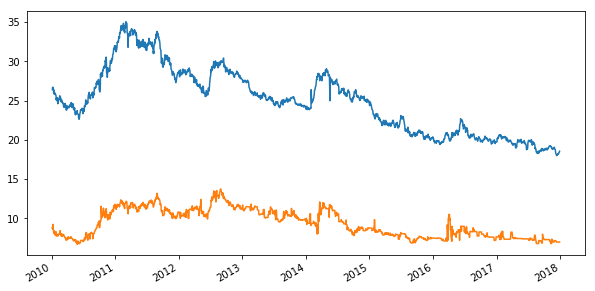

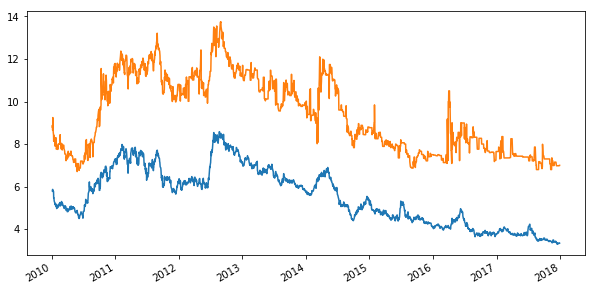

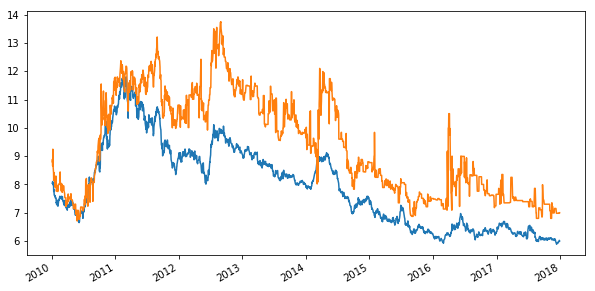

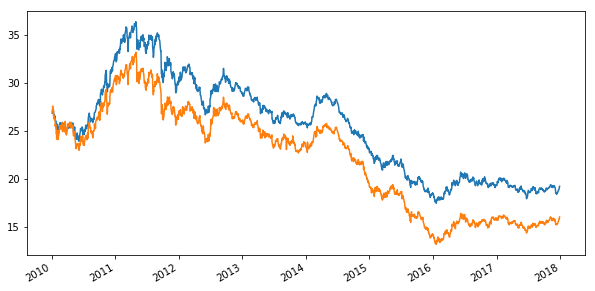

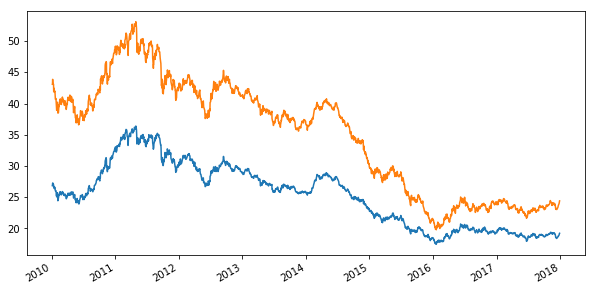

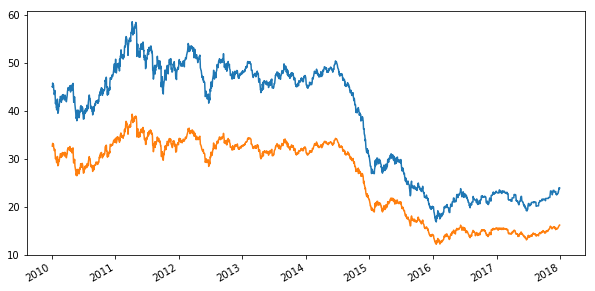

In [15]:
for i in range(6):
    plt.figure(figsize=(10,5))
    pairs_category[i][2]['X_train'].plot()
    pairs_category[i][2]['Y_train'].plot()

# 3. Clustering using Usupervised Learning

## PCA on returns

A purely fundamental approach is a one way to search for pairs, however breadth will likely be low. Sharpe can be maximized by having high breadth (high number of bets). With N stocks in the universe, there are N*(N-1)/2 pair-wise relationships. However, if we do a brute-force search over these, we will likely end up with many spurious results due to comparison bias. As such, we narrow down the search space in a reasonable way, assuming ETFs that share loadings to common factors (defined below) in the past should be related in the future.

**Obtain returns**

In [966]:
df_returns = data_processor.get_return_series(df_prices_train)
df_returns.head()

,AGQ,AMJ,CGW,DBA,DBB,DBC,DBE,DBO,DBP,DBS,...,UNL,USL,USO,USV,VDE,XES,XLE,XME,XOP,ZSL
2010-01-05,0.031780,0.013699,0.002137,0.006369,0.006981,0.001189,0.000000,0.009256,0.003004,0.016325,...,-0.029202,0.009024,0.003477,0.023771,0.010236,0.024763,0.008162,0.014386,0.008345,-0.031746
2010-01-06,0.041175,0.000676,-0.004797,0.005585,0.031196,0.017808,0.014665,0.012346,0.017142,0.019843,...,0.035583,0.012965,0.013858,0.014634,0.011514,0.019199,0.011975,0.039273,0.011264,-0.044496
2010-01-07,0.002912,-0.012492,-0.002678,-0.007775,-0.028571,-0.012442,-0.004129,-0.006969,-0.004315,0.002779,...,-0.013990,-0.007585,-0.006102,0.019227,-0.002390,0.000650,-0.001500,-0.007348,-0.005910,0.000000
2010-01-08,0.028809,0.015726,0.017186,0.002985,-0.007785,-0.000787,0.000370,0.004912,0.006628,0.014475,...,-0.013203,0.004538,0.005157,0.003023,0.007531,0.021097,0.006510,0.035072,0.007775,-0.026961
2010-01-11,0.007131,-0.010434,0.006864,-0.004464,0.009590,-0.003152,-0.010363,-0.005587,0.010889,0.004554,...,-0.033221,-0.007608,-0.009528,0.004138,-0.000793,-0.015257,-0.001327,-0.014303,-0.011119,-0.015113


In [967]:
print('Total number of possible pairs: ', len(df_returns.columns)*(len(df_returns.columns)-1)/2)

Total number of possible pairs:  2926.0


**Applying PCA on Returns**

- Protecting from `Curse of Dimensionality` - *source: https://stats.stackexchange.com/questions/232500/how-do-i-know-my-k-means-clustering-algorithm-is-suffering-from-the-curse-of-dim*: Perform a principle components analysis (PCA) and look at how the eigenvalues drop off. It is quite common that most of the variation exists in a couple of dimensions (which typically cut across the original dimensions of your dataset)

To analyze how many principal components we should be using, and accounting for the fact that too many features might incur curse of dimensionality, we proceed to visualize the explanatory power of the first 20 features. We observe that most of the information is in fact contained within the first features. We choose to keep the first 14.

In [968]:
# this show us the feature importance of the 
N_PRIN_COMPONENTS = 20
_, explained_variance = series_analyser.apply_PCA(N_PRIN_COMPONENTS, df_returns)
print(explained_variance)

[1.56802426e-02 5.77585478e-03 2.24341677e-03 9.18763070e-04
 8.31002568e-04 7.63191182e-04 5.61156857e-04 4.31498158e-04
 3.69145191e-04 2.73017926e-04 2.44440997e-04 2.33108307e-04
 2.19768705e-04 1.64100000e-04 1.53159624e-04 1.40104246e-04
 1.26549869e-04 1.17458744e-04 1.06130738e-04 9.80455305e-05]


In [969]:
N_PRIN_COMPONENTS = 5#config['PCA']['N_COMPONENTS']
X, explained_variance = series_analyser.apply_PCA(N_PRIN_COMPONENTS, df_returns)
print(explained_variance)

[0.01568024 0.00577585 0.00224342 0.00091876 0.000831  ]


**Clustering**

We will make use of the DBSCAN unsupervised clustering algorithm, which is available in scikit-learn. DBSCAN has advantages in this use case, specifically:

- DBSCAN does not cluster all stocks; it leaves out stocks which do not neatly fit into a cluster;
- No need to specify the number of clusters.

The clustering algorithm will give us sensible candidate pairs. We will need to do some validation in the next step.

In [954]:
clustered_series_all, clustered_series, counts, clf = series_analyser.apply_DBSCAN(config['clustering']['epsilon'],
                                                                                   config['clustering']['min_samples'],
                                                                                   X,
                                                                                   df_returns)

Clusters discovered: 9
Pairs to evaluate: 11


The epsilon parameter strongly dependens on the data. Because of the that, it is not obvious wether DBSCAN is the best algo.

In [955]:
print(counts)

2    3
8    2
7    2
6    2
5    2
4    2
3    2
1    2
0    2
dtype: int64


### Optimize according to Silhouette

When performing PCA, use number of components that maximizes the silhouette coefficient after clustering.

In [980]:
config['clustering']={"algo": "DBSCAN",
                      "epsilon": 0.4,
                      "min_samples": 2}
X, clustered_series_all, clustered_series, counts, clf = series_analyser.clustering_for_optimal_PCA(5,
                                                                                  15,
                                                                                  df_returns,
                                                                                  config['clustering'])


Number of components:  5
Returns shape:  (2012, 77)
Clusters discovered: 11
Pairs to evaluate: 172
Silhouette score  0.28483028615079264

Number of components:  6
Returns shape:  (2012, 77)
Clusters discovered: 12
Pairs to evaluate: 152
Silhouette score  0.27603613280905953

Number of components:  7
Returns shape:  (2012, 77)
Clusters discovered: 12
Pairs to evaluate: 135
Silhouette score  0.262224587703648

Number of components:  8
Returns shape:  (2012, 77)
Clusters discovered: 12
Pairs to evaluate: 132
Silhouette score  0.25589319363863716

Number of components:  9
Returns shape:  (2012, 77)
Clusters discovered: 12
Pairs to evaluate: 113
Silhouette score  0.23425011716266153

Number of components:  10
Returns shape:  (2012, 77)
Clusters discovered: 13
Pairs to evaluate: 60
Silhouette score  0.11462806166508087

Number of components:  11
Returns shape:  (2012, 77)
Clusters discovered: 13
Pairs to evaluate: 60
Silhouette score  0.12106232631510055

Number of components:  12
Returns s

In [981]:
counts

10    14
2      8
4      6
1      5
0      5
5      4
3      4
7      3
9      2
8      2
6      2
dtype: int64

**Fundamental analysis for clusters**

In [982]:
etfs, etfs_unique, tickers = \
            data_processor.read_ticker_excel(path='data/etfs/commodity_ETFs_long_updated.xlsx')

In [983]:
for label_n in range(len(counts)):
    elements_cluster_n = list(clustered_series[clustered_series == label_n].index)
    etfs_cluster_n = etfs_unique[etfs_unique['Ticker'].isin(elements_cluster_n)]
    print('\nCluster {}:\n{}'.format(label_n, etfs_cluster_n[['Ticker', 'Segment']]))


Cluster 0:
    Ticker                        Segment
375    CGW           Equity: Global Water
376    FIW           Equity: Global Water
277    NLR  Equity: Global Nuclear Energy
374    PHO           Equity: Global Water
377    PIO           Equity: Global Water

Cluster 1:
   Ticker                          Segment
0     DBA         Commodities: Agriculture
13    FUD         Commodities: Agriculture
17    GRU  Commodities: Agriculture Grains
18    RJA         Commodities: Agriculture
14    UAG         Commodities: Agriculture

Cluster 2:
    Ticker                    Segment
26     DBC  Commodities: Broad Market
61     DBE        Commodities: Energy
137    GSC  Commodities: Broad Market
28     GSG  Commodities: Broad Market
75     GSP  Commodities: Broad Market
134    RJI  Commodities: Broad Market
135    RJN        Commodities: Energy
65     UCI  Commodities: Broad Market

Cluster 3:
   Ticker                        Segment
41    DBO  Commodities: Energy Crude Oil
72    UGA   Commod

**Visualizing with t-sne**

In [960]:
def plot_TSNE(X, clf, clustered_series_all):
    """
    This function makes use of t-sne to visualize clusters in 2d.
    """
    X_tsne = TSNE(learning_rate=1000, perplexity=25, random_state=1337).fit_transform(X) 
    
    # visualization
    plt.figure(1, facecolor='white', figsize=(15,5))
    plt.clf()
    plt.axis('off')

    labels = clf.labels_
    plt.scatter(
        X_tsne[(labels!=-1), 0],
        X_tsne[(labels!=-1), 1],
        s=100,
        alpha=0.85,
        c=labels[labels!=-1],
        cmap=cm.Paired
    )

    plt.scatter(
        X_tsne[(clustered_series_all==-1).values, 0],
        X_tsne[(clustered_series_all==-1).values, 1],
        s=100,
        alpha=0.10
    )

    plt.title('T-SNE of all ETFs with DBSCAN Clusters Noted');

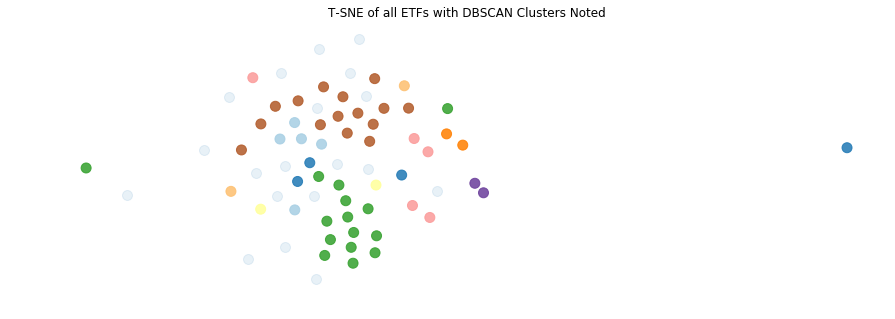

In [961]:
plot_TSNE(X,clf, clustered_series_all)

What can we conclude??
- First of all, the securities in each cluster are indeed from segments tham seem to be fundamentally related.
- Moreover, we see that some filtering is being performed, and the clustering goes further than a simple groupby segment would.

Let's proceed to plot the identified time series.

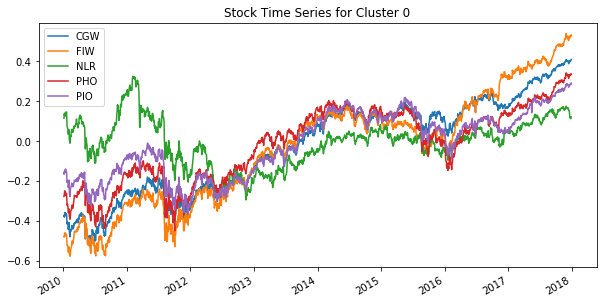

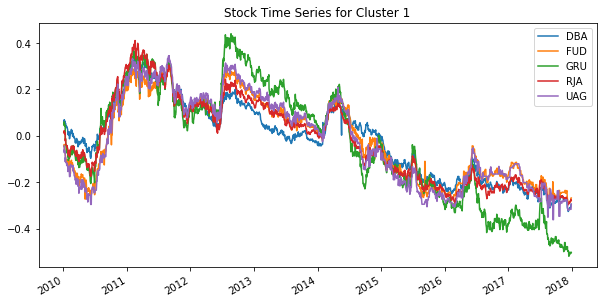

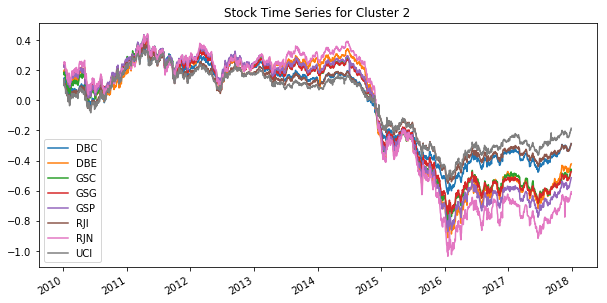

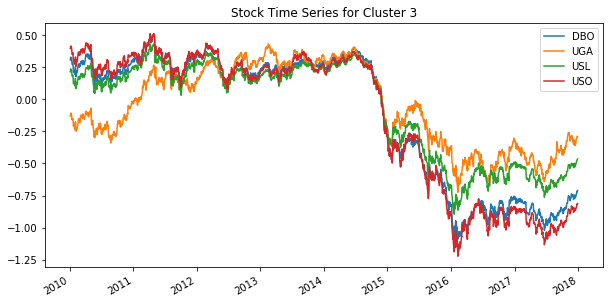

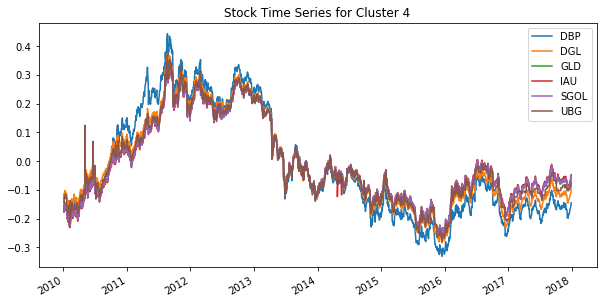

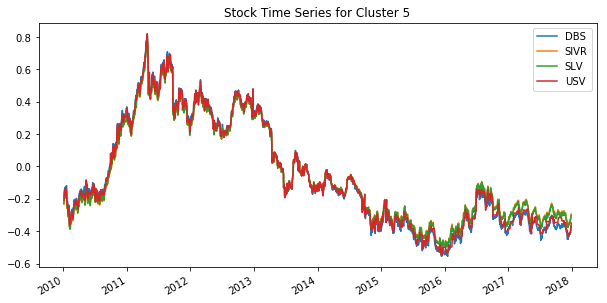

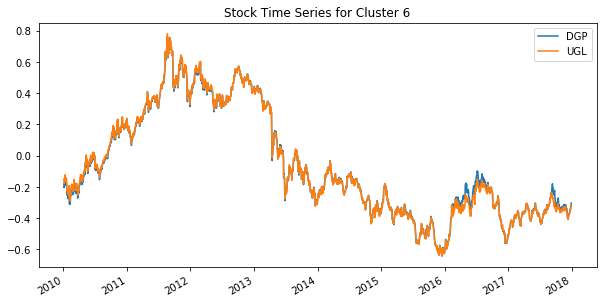

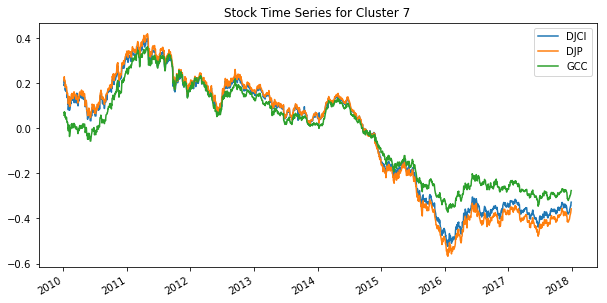

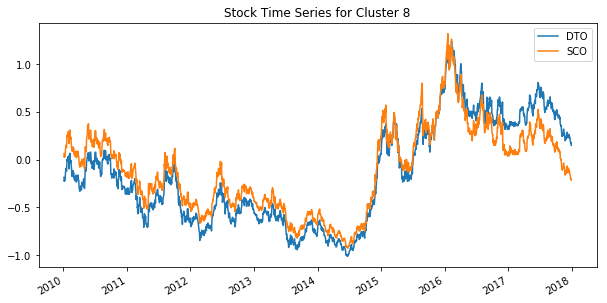

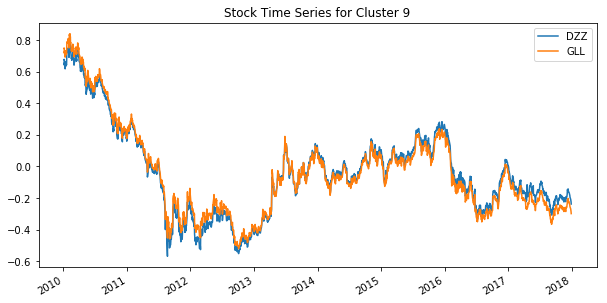

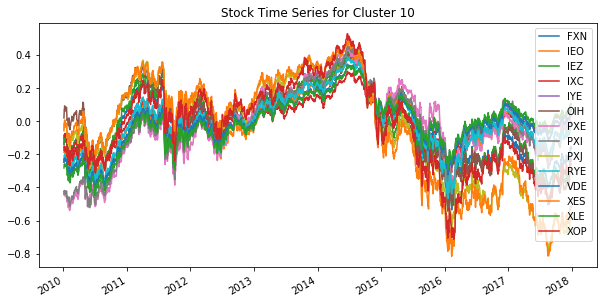

In [984]:
for clust in range(len(counts)):
    symbols = list(clustered_series[clustered_series==clust].index)
    means = np.log(df_prices_train[symbols].mean())
    series = np.log(df_prices_train[symbols]).sub(means)
    series.plot(title='Stock Time Series for Cluster %d' % clust, figsize=(10,5))

We now investigate whether it is possible to find cointegrated pairs within the clusters

In [985]:
pairs, unique_tickers = series_analyser.get_candidate_pairs(clustered_series=clustered_series,
                                                            pricing_df_train=df_prices_train,
                                                            pricing_df_test=df_prices_test,
                                                            min_half_life=config['pair_restrictions']['min_half_life'],
                                                            min_zero_crosings=config['pair_restrictions']['min_zero_crossings'],
                                                            p_value_threshold=config['pair_restrictions']['p_value_threshold'],
                                                            hurst_threshold=config['pair_restrictions']['hurst_threshold']
                                                            )

Found 13 pairs
The pairs contain 20 unique tickers


In [27]:
lookback_multiplier= config['trading']['lookback_multiplier']
entry_multiplier= config['trading']['entry_multiplier']
exit_multiplier= config['trading']['exit_multiplier']
# obtain trading filter info
if config['trading_filter']['active'] == 1:
    trading_filter = config['trading_filter']
else:
    trading_filter = None

In [28]:
n_years_train = round(len(df_prices_train)/240)

# Select one pair randomly

In [802]:
example = pairs[0]#[5]
example_spread = example[2]['spread']

**Verify stationarity**

In [30]:
series_analyser.check_for_stationarity(example_spread)

{'critical_values': {'1%': -3.433622218212895,
  '10%': -2.5675395171404802,
  '5%': -2.8629854902259004},
 'p_value': 0.003971290719714136,
 't_statistic': -3.7102482638339835}

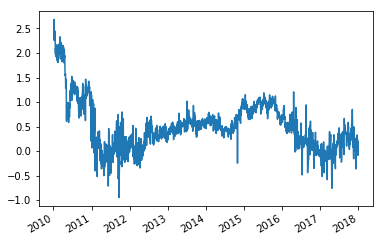

In [31]:
example_spread.plot()

**Create pct change series**

In [32]:
example_spread_pct_change = example_spread.pct_change()[1:]
series_analyser.check_for_stationarity(example_spread_pct_change)

{'critical_values': {'1%': -3.433610796445261,
  '10%': -2.5675368321236967,
  '5%': -2.8629804474582348},
 'p_value': 0.0,
 't_statistic': -22.550651790703466}

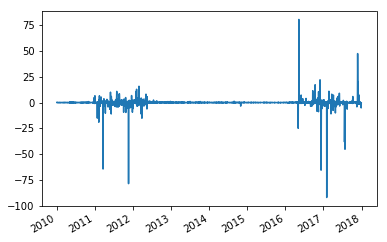

In [33]:
example_spread_pct_change.plot()

**Outliers from using pct change**

In [34]:
outliers_index_1 = example_spread_pct_change[abs(example_spread_pct_change)>40].index
outliers_index_0 = outliers_index_1 + pd.DateOffset(-1)
outliers_index = outliers_index_0.append(outliers_index_1)
outliers_index = outliers_index.sort_values()

In [35]:
example_spread.loc[outliers_index]

/Users/simaomoraessarmento/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  if __name__ == '__main__':


2011-03-22   -0.003667
2011-03-23    0.232560
2011-11-21   -0.002009
2011-11-22    0.155880
2016-05-09    0.006228
2016-05-10    0.507749
2016-12-08   -0.001679
2016-12-09    0.108321
2017-01-31   -0.002053
2017-02-01    0.186800
2017-07-25   -0.003978
2017-07-26    0.176022
2017-11-23         NaN
2017-11-24    0.071475
dtype: float64

### What should we use?

We can try to apply the same model for each and see what performs better.

### ARIMA

In [36]:
from statsmodels.tsa.arima_model import ARIMA

def apply_ARIMA(series):
    # fit model
    model = ARIMA(series, order=(5,1,0))
    model_fit = model.fit(disp=0)
    print(model_fit.summary())
    # plot residual errors
    residuals = pd.DataFrame(model_fit.resid)
    residuals.plot()
    plt.show()
    residuals.plot(kind='kde')
    plt.show()
    print(residuals.describe())

def rolling_ARIMA(series):
    X = series.values
    size = int(len(X) * 0.66)
    train, test = X[0:size], X[size:len(X)]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=(5,1,0))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        print('predicted=%f, expected=%f' % (yhat, obs))
    error = mean_squared_error(test, predictions)
    print('Test MSE: %.3f' % error)
    # plot
    plt.plot(test)
    plt.plot(predictions, color='red')
    plt.show()
    
    return predictions

/Users/simaomoraessarmento/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/simaomoraessarmento/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/simaomoraessarmento/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


predicted=0.941966, expected=0.936757
predicted=0.935344, expected=0.933714
predicted=0.921985, expected=0.911480
predicted=0.918891, expected=0.858738
predicted=0.902349, expected=0.892034
predicted=0.899304, expected=0.831020
predicted=0.875296, expected=0.872954
predicted=0.873377, expected=0.782783
predicted=0.836829, expected=0.783249
predicted=0.816146, expected=0.873207
predicted=0.836569, expected=0.873160
predicted=0.848224, expected=0.867417
predicted=0.849175, expected=0.954381
predicted=0.875919, expected=0.938069
predicted=0.900310, expected=0.951017


/Users/simaomoraessarmento/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=0.920591, expected=0.893826
predicted=0.907154, expected=1.021179
predicted=0.950848, expected=0.992146
predicted=0.970006, expected=1.044360
predicted=0.992326, expected=0.962606
predicted=0.975069, expected=0.949611
predicted=0.966906, expected=0.954251
predicted=0.970296, expected=1.005855
predicted=0.985572, expected=1.017343
predicted=0.995338, expected=1.073505
predicted=1.013485, expected=1.023207
predicted=1.012365, expected=1.016786
predicted=1.013671, expected=1.045442
predicted=1.028073, expected=1.079839
predicted=1.050537, expected=1.095330
predicted=1.065771, expected=1.064652
predicted=1.058123, expected=1.000973
predicted=1.036315, expected=1.044602
predicted=1.043206, expected=1.037930
predicted=1.046484, expected=1.026250
predicted=1.038629, expected=1.097244
predicted=1.052183, expected=0.950513
predicted=1.012666, expected=0.959645
predicted=0.994947, expected=0.847930
predicted=0.943745, expected=0.965059
predicted=0.958805, expected=0.755059
predicted=0.

/Users/simaomoraessarmento/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=0.960654, expected=0.962189
predicted=0.959143, expected=1.052696
predicted=1.000715, expected=1.118226
predicted=1.041928, expected=1.090207
predicted=1.050014, expected=1.043409
predicted=1.043161, expected=1.013315
predicted=1.033897, expected=1.061841
predicted=1.055051, expected=1.069052
predicted=1.064486, expected=1.026983
predicted=1.045257, expected=1.047878
predicted=1.039275, expected=0.989146
predicted=1.021812, expected=0.995644
predicted=1.016324, expected=0.998893
predicted=1.009182, expected=0.988639
predicted=1.000717, expected=0.948416
predicted=0.979578, expected=0.941681
predicted=0.962112, expected=1.000968
predicted=0.977528, expected=0.871935
predicted=0.939648, expected=0.968480
predicted=0.945654, expected=0.852236
predicted=0.910329, expected=0.816752
predicted=0.879951, expected=1.124724
predicted=0.965621, expected=0.940207
predicted=0.953701, expected=0.914423
predicted=0.931486, expected=0.882189
predicted=0.900145, expected=0.887625
predicted=0.

predicted=0.231446, expected=0.210792
predicted=0.226020, expected=0.212059
predicted=0.218306, expected=0.153834
predicted=0.191486, expected=0.330793
predicted=0.248826, expected=0.282012
predicted=0.262314, expected=0.532012
predicted=0.359031, expected=0.652012
predicted=0.464083, expected=0.752012
predicted=0.565337, expected=0.942012
predicted=0.707564, expected=0.142124
predicted=0.462955, expected=0.172425
predicted=0.363920, expected=0.272425
predicted=0.378477, expected=0.116181
predicted=0.315881, expected=0.186181
predicted=0.247252, expected=0.203819
predicted=0.183321, expected=0.211965
predicted=0.201120, expected=0.091965
predicted=0.151943, expected=-0.248035
predicted=-0.020329, expected=-0.438035
predicted=-0.175345, expected=-0.318035
predicted=-0.202099, expected=-0.218035
predicted=-0.185947, expected=0.256148
predicted=-0.017132, expected=0.086688
predicted=-0.027548, expected=-0.183312
predicted=-0.137852, expected=0.467289
predicted=0.117421, expected=0.072258


predicted=0.139503, expected=0.084088
predicted=0.114400, expected=0.091853
predicted=0.124546, expected=0.178604
predicted=0.156031, expected=0.195910
predicted=0.172742, expected=0.205910
predicted=0.175117, expected=0.201393
predicted=0.173264, expected=0.219666
predicted=0.192721, expected=0.366718
predicted=0.271604, expected=0.146718
predicted=0.209012, expected=0.213976
predicted=0.208538, expected=0.293976
predicted=0.250513, expected=0.363976
predicted=0.304841, expected=0.274436
predicted=0.282036, expected=0.394436
predicted=0.313158, expected=0.474436
predicted=0.385176, expected=0.342107
predicted=0.362695, expected=0.124548
predicted=0.254113, expected=-0.138701
predicted=0.093823, expected=-0.108701
predicted=0.047620, expected=0.028604
predicted=0.070737, expected=0.088604
predicted=0.071089, expected=0.241853
predicted=0.113232, expected=0.077083
predicted=0.061729, expected=0.107083
predicted=0.076989, expected=0.169318
predicted=0.128427, expected=0.139825
predicted=

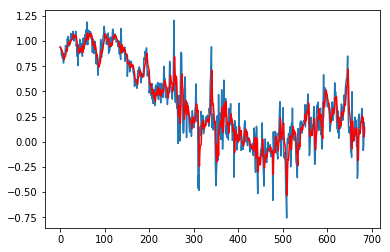

In [37]:
arima_predictions = rolling_ARIMA(example_spread)

In [38]:
print('RMSE for predicting the spread pct change is {}'.format(np.sqrt(0.023)))

RMSE for predicting the spread pct change is 0.15165750888103102


Predicting the spread directly seems more appropriate.

# Naive benchmark

In [588]:
# define data size - select two years for validation
train_val_split = '2016-01-01' # initial date

y_series_val = example_spread[train_val_split:]
naive_predictions = pd.Series(data=[example_spread.mean()]*len(y_series_val), index=y_series_val.index)
print('Naive MAE: ', abs(y_series_val-naive_predictions).mean())

Naive MAE:  0.3481120157088696


# Trying some ANN based models

In [40]:
def series_to_supervised(data, index=None, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
    data: Sequence of observations as a list or NumPy array.
    n_in: Number of lag observations as input (X).
    n_out: Number of observations as output (y).
    dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    if index is None:
        df = pd.DataFrame(data)
    else:
        df = pd.DataFrame(data, index=index)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def plot_loss(history, title):
    """
    Function to plot loss function.
    Arguments:
    history: History object with data from training.
    title: Plot title.
    """
    
    plt.plot(history.history['loss'], label = "training")
    plt.plot(history.history['val_loss'], label = "validation")

## MLP

In [803]:
def apply_MLP(X, y, validation_data, n_in, hidden_nodes, epochs, optimizer, loss_fct):
    # reset seed
    #np.random.seed(0) # NumPy
    #tf.set_random_seed(2) # Tensorflow
    #random.seed(3) # Python
 
    # define validation set
    X_val = validation_data[0]
    y_val = validation_data[1]
    
    model = Sequential()
    model.add(Dense(hidden_nodes, activation='relu', input_dim=n_in))
    #model.add(Dropout(0.2))
    #model.add(Dense(hidden_nodes, activation='relu', input_dim=n_in))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss=loss_fct, metrics=['mae'])
    model.summary()
    
    # simple early stopping
    #es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

    history = model.fit(X, y, epochs=epochs, verbose=0, validation_data=validation_data, 
                        shuffle=False)#, callbacks=[es])
    
    train_score = model.evaluate(X, y, verbose=0)
    val_score = model.evaluate(X_val, y_val, verbose=0)
    score = {'train':train_score, 'val':val_score}
    
    predictions = model.predict(X_val)
    
    print('------------------------------------------------------------')
    print('The mse train loss is: ', train_score[0])
    print('The mae train loss is: ', train_score[1])
    print('The mse test loss is: ', val_score[0])
    print('The mae test loss is: ', val_score[1])
    print('------------------------------------------------------------')
    
    return history, score, predictions

def grid_search_MLP(X, y, validation_data, n_in, hidden_nodes, epochs, optimizer, loss_fct):
    """
    Funcion to perform grid search.
    """
    models = [] # saves parameters and score for every model
    best_model = {'neurons':0,'mse':9999,'mae':9999, 'history':None, 'predictions':None} 
    for i,neurons in enumerate(hidden_nodes):
        history, score, predictions = apply_MLP(X, y, validation_data, n_in, neurons, epochs,
                                                optimizer, loss_fct)
        
        # save reference to best model
        # score is loss! So being smaller is actually better
        if score['val'][1] < best_model['mae']:
            # update best model
            best_model['neurons']=neurons
            best_model['mse']=score['val'][0]
            best_model['mae']=score['val'][1]
            best_model['history']=history
            best_model['predictions']=predictions

        # simply save score
        # this way we save a bit of memory
        models.append({'neurons':neurons,
                       'mse':score['val'][0],
                       'mae':score['val'][1]
                      })
   
    print('The best model obtained a MAE score of ', best_model['mae'])
    
    return models, best_model    

In [804]:
# parameters
n_in = 5
epochs = 200
hidden_nodes = 5#[2,5,10,20]
loss_fct = 'mse'
optimizer = 'adam'
train_val_split = '2016-01-01' # initial date

In [847]:
# normalize data
example_spread = example[2]['spread']
standardization_dict = {'mean':example_spread.mean(),'std':np.std(example_spread)}
example_spread_norm = (example_spread - example_spread.mean())/np.std(example_spread)

# prepare data
forecasting_data = series_to_supervised(list(example_spread_norm), example_spread_norm.index, n_in, 1, dropnan=True)

# define dataset
X_series = forecasting_data.drop(columns='var1(t)')
y_series = forecasting_data['var1(t)']
X = np.asarray(forecasting_data.drop(columns='var1(t)').values)
y = np.asarray(forecasting_data[['var1(t)']].values)

# split
X_series_train = X_series[:train_val_split]
X_series_val= X_series[train_val_split:]
y_series_train = y_series[:train_val_split]
y_series_val = y_series[train_val_split:]

X_train = X_series_train.values
X_val = X_series_val.values
y_train = y_series_train.values
y_val = y_series_val.values

In [848]:
# train one configuration
mlp_history, mlp_score, mlp_predictions = apply_MLP(X_train, y_train, (X_val, y_val), n_in, hidden_nodes,
                                                    epochs, optimizer, loss_fct)
mlp_predictions = pd.Series(data=mlp_predictions.flatten(), index=y_series_val.index)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_341 (Dense)            (None, 5)                 30        
_________________________________________________________________
dense_342 (Dense)            (None, 1)                 6         
Total params: 36
Trainable params: 36
Non-trainable params: 0
_________________________________________________________________
------------------------------------------------------------
The mse train loss is:  0.03763641245489897
The mae train loss is:  0.1276407265583938
The mse test loss is:  0.025744097838715223
The mae test loss is:  0.12366994565156535
------------------------------------------------------------


In [159]:
# grid search
models_mlp, best_model_mlp = grid_search_MLP(X_train, y_train, (X_val, y_val), n_in, hidden_nodes,
                                             epochs, optimizer, loss_fct)
mlp_predictions = pd.Series(data=best_model_mlp['predictions'].flatten(), index=y_series_val.index)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_181 (Dense)            (None, 2)                 12        
_________________________________________________________________
dense_182 (Dense)            (None, 1)                 3         
Total params: 15
Trainable params: 15
Non-trainable params: 0
_________________________________________________________________
------------------------------------------------------------
The mse train loss is:  0.15452614653272084
The mae train loss is:  0.25326630706528586
The mse test loss is:  0.09745497896390802
The mae test loss is:  0.22059830392108243
------------------------------------------------------------
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_183 (Dense)            (None, 5)                 30        
________________________________________________

In [202]:
def return_dict(i):
    example={'i':i}
    return example

testing = []
for i in range(3):
    example = return_dict(i)
    testing.append(example)
testing

[{'i': 0}, {'i': 1}, {'i': 2}]

In [143]:
# grid search with 2 layers
models_mlp, best_model_mlp = grid_search_MLP(X_train, y_train, (X_val, y_val), n_in, hidden_nodes,
                                             epochs, optimizer, loss_fct)
mlp_predictions = pd.Series(data=best_model_mlp['predictions'].flatten(), index=y_series_val.index)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_160 (Dense)            (None, 2)                 22        
_________________________________________________________________
dropout_1 (Dropout)          (None, 2)                 0         
_________________________________________________________________
dense_161 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_162 (Dense)            (None, 1)                 3         
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________
------------------------------------------------------------
The mse train loss is:  0.03330118791480739
The mae train loss is:  0.1301538735089532
The mse test loss is:  0.029661091767527438
The mae test loss is:  0.1294144606369513
--------------------------------------------

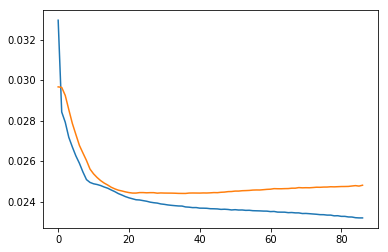

In [97]:
plot_loss(mlp_history, 'mlp_loss')

**Try trading using simple MLP model**

In [867]:
def destandardize(predictions, spread_mean, spread_std):
    """
    This function transforms the normalized predictions into the original space.
    """
    return predictions*spread_std + spread_mean

def forecast_trading(X, Y, spread, beta, predictions, long_threshold, short_threshold, auto_threshold=False,
                     standardization_dict=None):
    """
    This function will set the trading positions based on the forecasted spread.
    For each day, the function compares the predicted spread for that day with the
    true value of the spread in tha day before, giving the predicted spread pct change.
    In case it is larger than the threshold, a position is entered.
    Note: because a position entered in day n is only taken into account on the day after,
    we shift the entered positions
    """
    # 1. Get predictions pct_change
    # we want to see the pct change of the prediction compared
    # to the true value but the previous instant time, because we 
    # are interested in seeing the temporal % change
    predictions = destandardize(predictions, standardization_dict['mean'], standardization_dict['std'])
    predictions_pct_change = (predictions-spread.shift(1))/np.std(spread)*100#abs(spread.shift(1))*100#
    if auto_threshold:
        auto_threshold = np.abs(predictions_pct_change).describe()['25%']
        long_threshold = auto_threshold
        short_threshold = -auto_threshold
    
    # 2. Define trading timings
    # Note: If we want to enter a position at the beginning of day N, 
    # because of the way pnl is calculated the position is entered 
    # in the previous day. 
    # Example: In day 23 the percentage change is 55% (wrt day 22). If we were to enter the
    # position in day 23, the following code would not consider the gains during day 23, even if we had
    # set the position in the morning. (it conly considers the gains for the next days)
    # Thus, to workaoround, we enter the position at day 22 (at night), and it considers the gains for day 23
    numUnits = pd.Series(data=[0]*len(spread), index=spread.index)
    longsEntry = predictions_pct_change > long_threshold
    longsEntry= longsEntry.shift(-1).fillna(False)
    numUnits[longsEntry] = 1.
    shortsEntry = predictions_pct_change < short_threshold
    shortsEntry= shortsEntry.shift(-1).fillna(False)
    numUnits[shortsEntry] = -1
    
    # 3. Define positions according to cointegration equation
    X_positions = numUnits*(-beta*X)
    Y_positions = numUnits*Y
    
    # 4. Calculate P&L and Returns
    X_returns = (X - X.shift(periods=1))/X.shift(periods=1)
    Y_returns = (Y - Y.shift(periods=1))/Y.shift(periods=1)
    pnl_X = X_positions.shift(periods=1)*X_returns # -beta * X *%return (beta included in X_positions)
    pnl_Y = Y_positions.shift(periods=1)*Y_returns
    pnl = pnl_X + pnl_Y
    pnl = pnl.fillna(0)
    
    ret = (pnl/(np.abs(X_positions.shift(periods=1))+np.abs(Y_positions.shift(periods=1))))
    # use without fillna(0) according to git version, so that when position is not entered it is not taken into
    # account when calculating the avg return
    ret= ret.fillna(0)
    
    # 5. Calculate some metrics
    n_years = round(len(Y) / 240) # approx of # of years, as each year does not have exactly 252 days
    time_in_market = 252. * n_years
    # apr = ((np.prod(1.+ret))**(time_in_market/len(ret)))-1
    if np.std(ret) == 0:
        sharpe = 0
    else:
        sharpe = np.sqrt(time_in_market)*np.mean(ret)/np.std(ret)
    print('Sharpe: ',sharpe)
        
    # summarize
    bins = [-np.inf, 0, np.inf]
    names = ['-1', '1']
    summary = pd.DataFrame(data={'prediction(t)':predictions.values,
                                 'spread(t)':spread.values,
                                 'predicted_change(%)':predictions_pct_change,
                                 'position_during_day':numUnits.shift(1).fillna(0),
                                 'pnl':pnl,
                                 'ret':ret,
                                 'predicted_direction':pd.cut(predictions_pct_change, bins, labels=names),
                                 'true_direction':pd.cut(spread.diff(), bins, labels=names)
                                },
                           index = spread.index)
    
    return pnl, ret, summary, sharpe

In [849]:
pnl, ret, summary, sharpe = forecast_trading(example[2]['X_train'][train_val_split:],
                                             example[2]['Y_train'][train_val_split:],
                                             example_spread[train_val_split:],
                                             example[2]['coint_coef'],
                                             mlp_predictions,
                                             #models[0]['predictions'],
                                             0, 0,
                                             auto_threshold=True,
                                             standardization_dict=standardization_dict)
total_roi = (np.cumprod(1 + ret) - 1).iloc[-1]* 100
print('Cum return:', total_roi)
print('Annual ROI: ', ((1 + (total_roi / 100)) ** (1 / float(2)) - 1) * 100)

Sharpe:  1.3135056929447797
Cum return: 11.6502512170096
Annual ROI:  5.664682471017524


In [871]:
summary

,pnl,position_during_day,predicted_change(%),predicted_direction,prediction(t),ret,spread(t),true_direction
2016-01-04,0.000000,0.0,NaN,NaN,-1.630068,0.000000,-1.724521,NaN
2016-01-05,0.084736,1.0,20.824619,1,-1.665693,0.003076,-1.639785,1
2016-01-06,0.040123,-1.0,-5.718065,-1,-1.655938,0.001479,-1.679909,-1
2016-01-07,-0.000261,1.0,1.240241,1,-1.676405,-0.000010,-1.680169,-1
2016-01-08,0.012261,1.0,1.626571,1,-1.675575,0.000472,-1.667908,1
2016-01-11,-0.018377,-1.0,-4.081049,-1,-1.679437,-0.000709,-1.649531,1
2016-01-12,-0.129700,-1.0,-5.374802,-1,-1.664714,-0.005199,-1.519831,1
2016-01-13,-0.009485,-1.0,-29.670342,-1,-1.603647,-0.000385,-1.510346,1
2016-01-14,0.020289,-1.0,-23.652879,-1,-1.577163,0.000830,-1.530635,-1
2016-01-15,-0.092539,-1.0,-10.592935,-1,-1.560559,-0.003766,-1.438096,1


In [714]:
# perceber como é que melhora tanto quando eu baixo o threshold
# - ver accuracy da direção - parece ser a mesma para diferentes threhsolds.
# Para -70,70 a accuracy é muito boa mas as cum returns nem por isso. Por ter menos trades pode não compensar
# usar este parametro para treinar a rede possivelmente pode ser melhor - mudar para classificação
# criar threshold adaptativo

**Naive Benchmark**

In [864]:
for i in range(len(pairs)):
    print('---------------------------------------------------------------')
    print('Pair {}: '.format(i))
    pnl, ret, summary, sharpe = forecast_trading(models[i]['info']['X_train'][train_val_split:],
                                                 models[i]['info']['Y_train'][train_val_split:],
                                                 models[i]['info']['spread'][train_val_split:],
                                                 models[i]['info']['coint_coef'],
                                                 #models[i]['predictions'],
                                                 pd.Series(data=[models[i]['info']['spread'][train_val_split:].mean()]*len(models[i]['info']['spread'][train_val_split:]),
                                                           index=models[i]['info']['spread'][train_val_split:].index),
                                                 0, 0,
                                                 auto_threshold=True,
                                                 standardization_dict=models[i]['standardization_dict'])
    total_roi = (np.cumprod(1 + ret) - 1).iloc[-1]* 100
    print('Cum return:', total_roi)
    print('Annual ROI: ', ((1 + (total_roi / 100)) ** (1 / float(2)) - 1) * 100)

---------------------------------------------------------------
Pair 0: 
Sharpe:  2.13004742468447
Cum return: 13.679478549933833
Annual ROI:  6.6205789469996335
---------------------------------------------------------------
Pair 1: 
Sharpe:  0.9391899748383454
Cum return: 3.436637555714883
Annual ROI:  1.7038040368770435
---------------------------------------------------------------
Pair 2: 
Sharpe:  2.81556797944289
Cum return: 18.263460271127997
Annual ROI:  8.749004717803288
---------------------------------------------------------------
Pair 3: 
Sharpe:  1.7214180857174013
Cum return: 7.254117007440453
Annual ROI:  3.5635635768876295
---------------------------------------------------------------
Pair 4: 
Sharpe:  1.5713968407463106
Cum return: 9.054800936423813
Annual ROI:  4.429306679889344
---------------------------------------------------------------
Pair 5: 
Sharpe:  4.051392970541559
Cum return: 39.739590833817196
Annual ROI:  18.211501485184243
--------------------------

**MLP performance**

In [852]:
model_config = {"n_in": 5,
                "n_out": 1,
                "epochs": 200,
                "hidden_nodes":5,
                "loss_fct": "mse",
                "optimizer": "adam",
                "train_val_split": '2016-01-01'}
models = forecasting_trader.train_models(pairs, model_config)

Under construction
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_343 (Dense)            (None, 5)                 30        
_________________________________________________________________
dense_344 (Dense)            (None, 1)                 6         
Total params: 36
Trainable params: 36
Non-trainable params: 0
_________________________________________________________________
------------------------------------------------------------
The mse train loss is:  0.04148829407074127
The mae train loss is:  0.13098732918203868
The mse test loss is:  0.027701482337864326
The mae test loss is:  0.12916545002586088
------------------------------------------------------------
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_345 (Dense)            (None, 5)                 30        
____________________________

In [870]:
for i in range(len(pairs)):
    print('---------------------------------------------------------------')
    print('Pair {}: '.format(i))
    pnl, ret, summary, sharpe = forecast_trading(models[i]['info']['X_train'][train_val_split:],
                                                 models[i]['info']['Y_train'][train_val_split:],
                                                 models[i]['info']['spread'][train_val_split:],
                                                 models[i]['info']['coint_coef'],
                                                 models[i]['predictions'],
                                                 -1, 1,
                                                 auto_threshold=False,
                                                 standardization_dict=models[i]['standardization_dict'])
    total_roi = (np.cumprod(1 + ret) - 1).iloc[-1]* 100
    print('Cum return:', total_roi)
    print('Annual ROI: ', ((1 + (total_roi / 100)) ** (1 / float(2)) - 1) * 100)

---------------------------------------------------------------
Pair 0: 
Sharpe:  0.6910643047512438
Cum return: 6.438324099093173
Annual ROI:  3.1689508035693814
---------------------------------------------------------------
Pair 1: 
Sharpe:  1.2041600976277334
Cum return: 6.5563414919898255
Annual ROI:  3.226131135478405
---------------------------------------------------------------
Pair 2: 
Sharpe:  3.5067449278985072
Cum return: 35.565821935741695
Annual ROI:  16.43273677782451
---------------------------------------------------------------
Pair 3: 
Sharpe:  2.9190340809259046
Cum return: 22.692623929141085
Annual ROI:  10.766702546000296
---------------------------------------------------------------
Pair 4: 
Sharpe:  0.26674085112530915
Cum return: 1.7943860596878247
Annual ROI:  0.8932039632441269
---------------------------------------------------------------
Pair 5: 
Sharpe:  5.12640041921828
Cum return: 94.46911951991868
Annual ROI:  39.45218518184599
----------------------

In [727]:
summary = summary[(summary['predicted_change(%)']>70) | (summary['predicted_change(%)']<-70)]
acc = len(np.where(summary.predicted_direction == summary.true_direction)[0])/len(summary)*100
acc

72.91666666666666

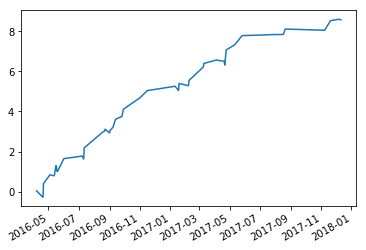

In [728]:
cum_pnl = np.cumsum(summary.pnl)
cum_pnl.plot()

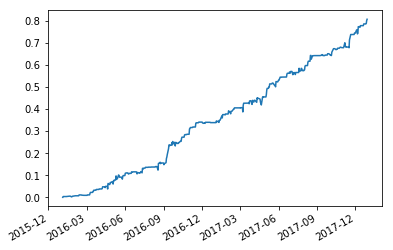

In [729]:
(np.cumprod(1 + ret) - 1).plot()

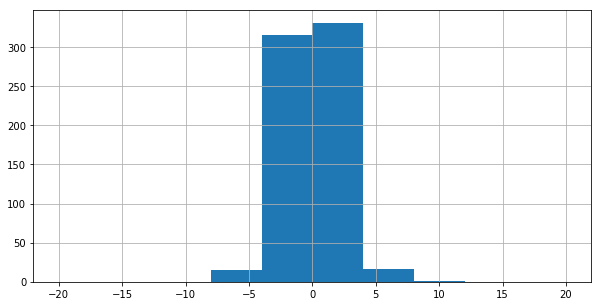

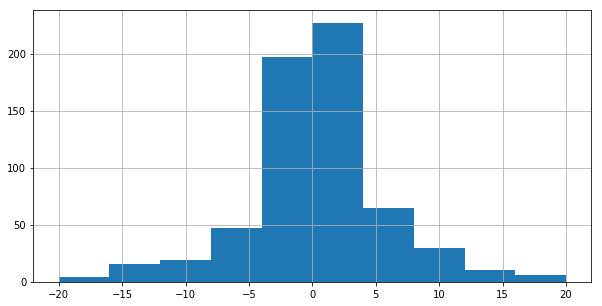

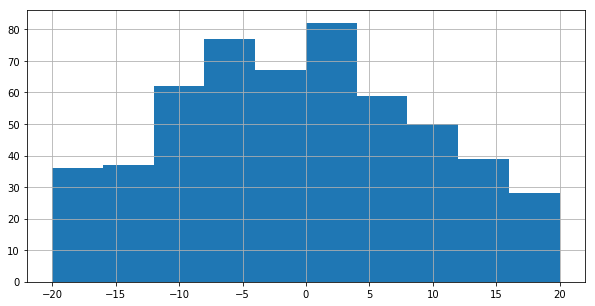

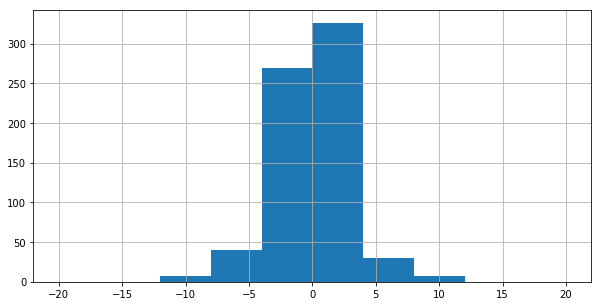

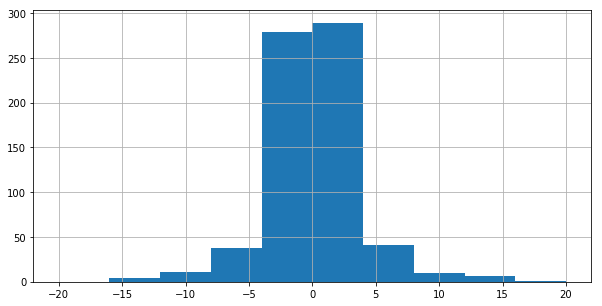

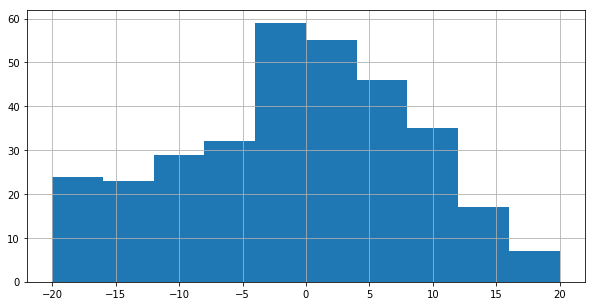

In [543]:
for i in range(6):
    example = pairs[i]
    example_spread = example[2]['spread']
    example_spread = example_spread[train_val_split:][n_in:]
    #print('spread percentage change: ', (example_spread.pct_change()*100).mean())
    plt.figure(figsize=(10,5))
    (example_spread.pct_change()*100).hist(range=(-20, 20))
    #alternative1 = ((example_spread-example_spread.shift(1))/np.std(example_spread)*100).mean()
    #print('alternative 1:', alternative1)

In [ ]:
# try plotting percentage deviations w.r.t std.deviation

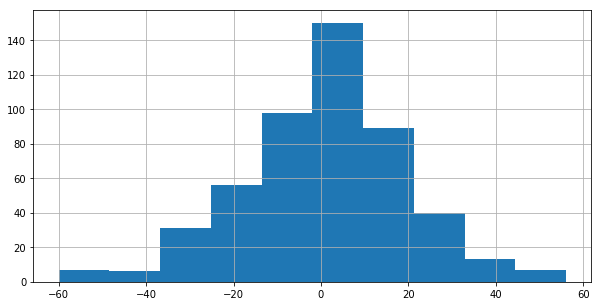

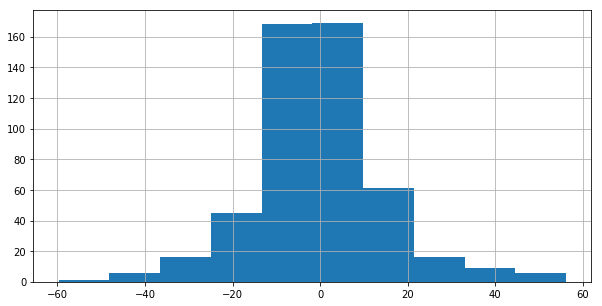

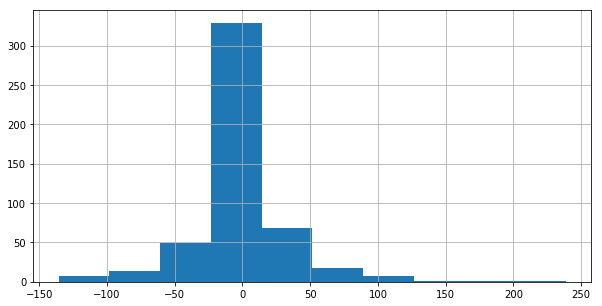

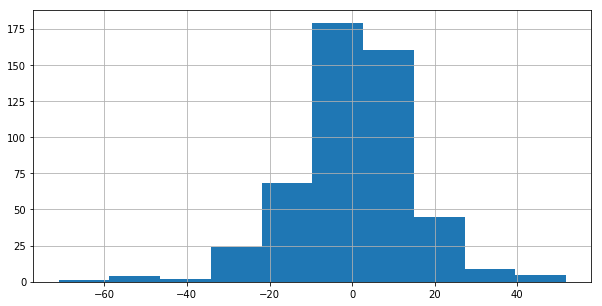

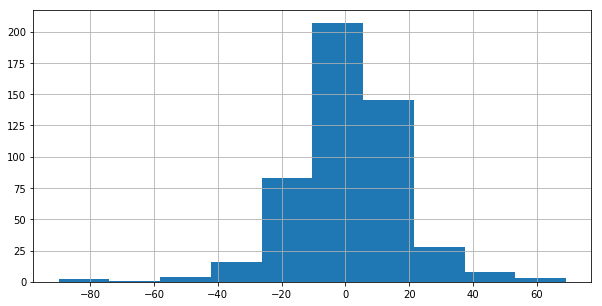

In [753]:
for i in range(6):
    example = pairs[i]
    example_spread = example[2]['spread']
    example_spread = example_spread[train_val_split:][n_in:]
    #print('spread percentage change: ', (example_spread.pct_change()*100).mean())
    plt.figure(figsize=(10,5))
    #(example_spread.pct_change()*100).hist(range=(-20, 20))
    alternative1 = ((example_spread-example_spread.shift(1))/np.std(example_spread)*100)
    alternative1.hist()#range=(-20, 20))

In [758]:
alternative1.describe()

count    497.000000
mean       0.710888
std       17.248188
min      -89.894630
25%       -8.239816
50%        0.964706
75%       10.023167
max       69.142147
dtype: float64

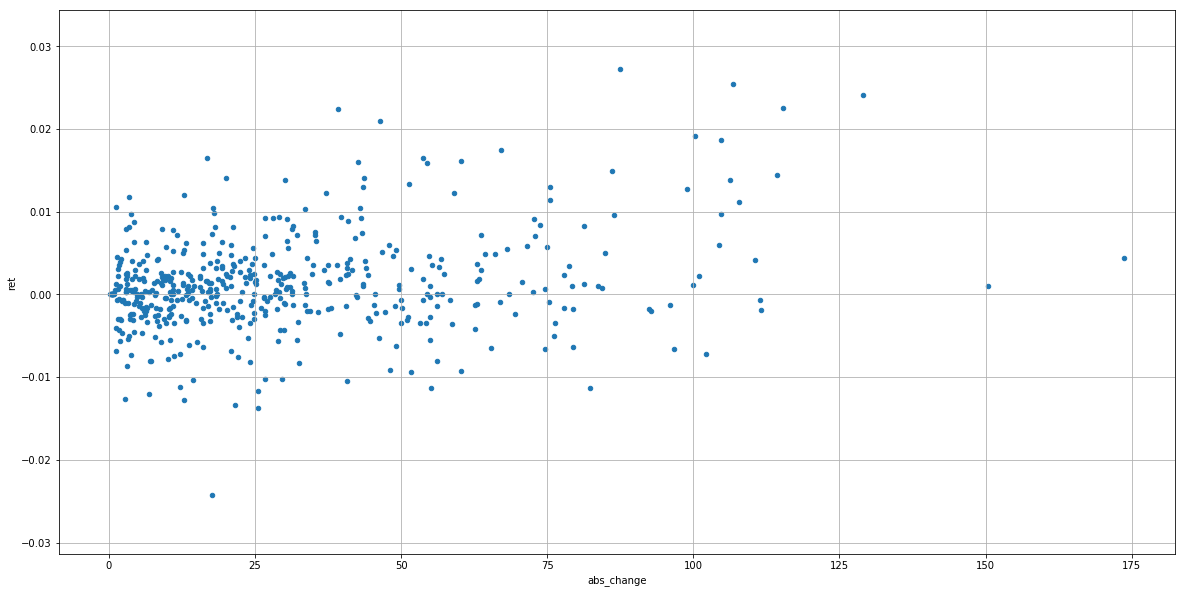

In [637]:
summary['abs_change']=np.abs(summary['predicted_change(%)'])
summary.plot.scatter(x='abs_change', y='ret', figsize=(20,10), grid=True)

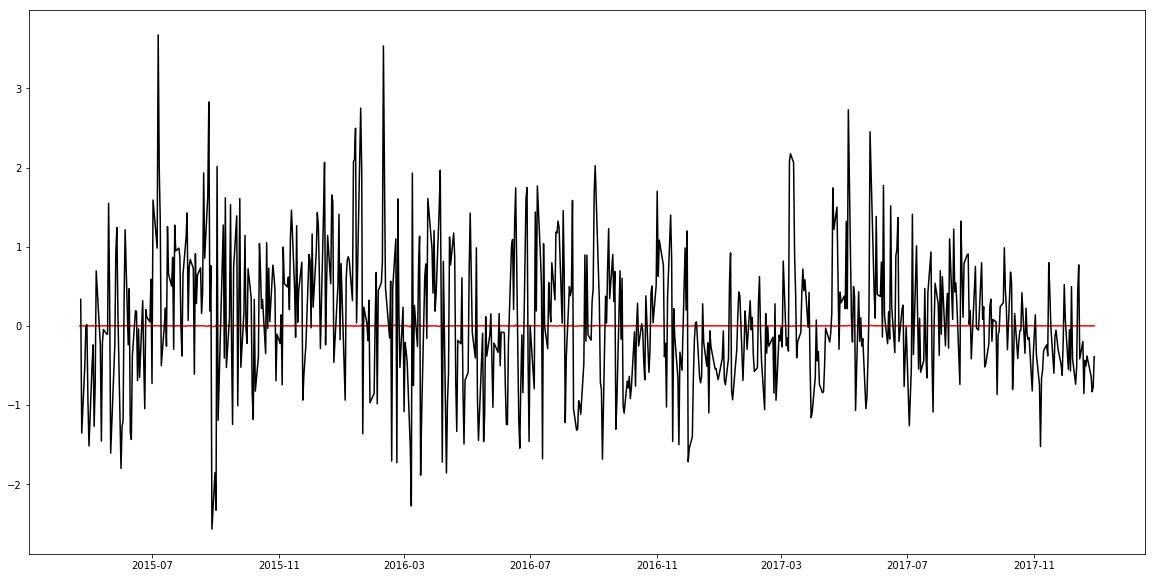

In [524]:
# Rerun y_test!
plt.close()
plt.figure(figsize=(20,10))
plt.plot(summary.ret, color='red')
plt.plot(summary['predicted_spread_change(%)'], color='black')
plt.show()

**Important:** On day n, I will make the prediction for day n, and not for day n+1. 

# Modelling with more complex models

## CNN

In [228]:
def apply_CNN(X, y, validation_data, n_in, hidden_nodes, epochs, optimizer, loss_fct):
    # reshape data for conv net
    X = X.reshape((X.shape[0], X.shape[1], 1))
    X_val = validation_data[0].reshape((validation_data[0].shape[0], validation_data[0].shape[1], 1))
    y_val = validation_data[1]
    
   # define model
    model = Sequential()
    model.add(Conv1D(filters=16, kernel_size=2, activation='relu', input_shape=(n_in, 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(hidden_nodes, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss=loss_fct, metrics=['mae'])
    model.summary()
    
    # simple early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
    
    # fit model
    history = model.fit(X, y, epochs=epochs, verbose=0, validation_data=(X_val, y_val), callbacks=[es])
    train_score = model.evaluate(X, y, verbose=0)
    score = model.evaluate(X_val, y_val, verbose=0)
    predictions = model.predict(X_val)
    
    print('The mse train loss is: ', train_score[0])
    print('The mae train loss is: ', train_score[1])
    print('The mse test loss is: ', score[0])
    print('The mae test loss is: ', score[1])
    
    return history, score, predictions

In [229]:
# parameters
n_in = 5
epochs = 200
hidden_nodes = 20
loss_fct = 'mse'
optimizer = 'Adam'
train_val_split = int(0.66*len(example_spread))

In [230]:
# prepare data
forecasting_data = series_to_supervised(list(example_spread), example_spread.index, n_in, 1, dropnan=True)

# define dataset
X_series = forecasting_data.drop(columns='var1(t)')
y_series = forecasting_data['var1(t)']
X = np.asarray(forecasting_data.drop(columns='var1(t)').values)
y = np.asarray(forecasting_data[['var1(t)']].values)

# split
X_series_train = X_series[:train_val_split]
X_series_val= X_series[train_val_split:]
y_series_train = y_series[:train_val_split]
y_series_val = y_series[train_val_split:]

X_train = X[:train_val_split]
X_val = X[train_val_split:]
y_train = y[:train_val_split]
y_val = y[train_val_split:]

In [48]:
cnn_history, cnn_score, cnn_predictions = apply_CNN(X_train, y_train, (X_val, y_val), n_in,
                                                   hidden_nodes, epochs, optimizer, loss_fct)
cnn_predictions = pd.Series(data=cnn_predictions.flatten(), index=y_series_val.index)

NameError: name 'apply_CNN' is not defined

The mse test loss is:  0.02458564558011644
The mae test loss is:  0.11168607561027302


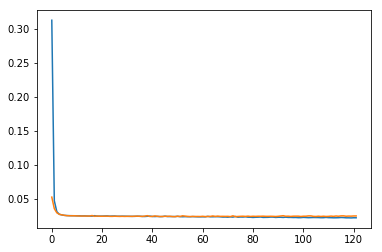

In [232]:
print('The mse test loss is: ', cnn_score[0])
print('The mae test loss is: ', cnn_score[1])
plot_loss(cnn_history, 'cnn_loss')

## RNN

In [312]:
def apply_RNN(X, y, validation_data, n_in, hidden_nodes, epochs, optimizer, loss_fct):
    # reshape data for conv net
    X = X.reshape((X.shape[0], X.shape[1], 1))
    X_val = validation_data[0].reshape((validation_data[0].shape[0], validation_data[0].shape[1], 1))
    y_val = validation_data[1]

    # define model
    model = Sequential()
    model.add(LSTM(hidden_nodes, activation='relu', input_shape=(n_in, 1)))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss=loss_fct, metrics=['mae'])
    model.summary()

    # simple early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
    
    # fit model
    history = model.fit(X, y, epochs=epochs, verbose=0, validation_data=(X_val, y_val), callbacks=[es])
    train_score = model.evaluate(X, y, verbose=0)
    score = model.evaluate(X_val, y_val, verbose=0)
    predictions = model.predict(X_val)
    
    print('The mse train loss is: ', train_score[0])
    print('The mae train loss is: ', train_score[1])
    print('The mse test loss is: ', score[0])
    print('The mae test loss is: ', score[1])
    
    return history, score, predictions

In [308]:
# parameters
n_in = 10
epochs = 500
hidden_nodes = 50
loss_fct = 'mse'
optimizer = 'Adam'
train_val_split = int(0.8*len(example_spread))

In [309]:
# prepare data
forecasting_data = series_to_supervised(list(example_spread), example_spread.index, n_in, 1, dropnan=True)

# define dataset
X_series = forecasting_data.drop(columns='var1(t)')
y_series = forecasting_data['var1(t)']
X = np.asarray(forecasting_data.drop(columns='var1(t)').values)
y = np.asarray(forecasting_data[['var1(t)']].values)

# split
X_series_train = X_series[:train_val_split]
X_series_val= X_series[train_val_split:]
y_series_train = y_series[:train_val_split]
y_series_val = y_series[train_val_split:]

X_train = X[:train_val_split]
X_val = X[train_val_split:]
y_train = y[:train_val_split]
y_val = y[train_val_split:]

In [310]:
rnn_history, rnn_score, rnn_predictions = apply_RNN(X_train, y_train, (X_val, y_val), n_in,
                                                   hidden_nodes, epochs, optimizer, loss_fct)
rnn_predictions = pd.Series(data=rnn_predictions.flatten(), index=y_series_val.index)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 50)                10400     
_________________________________________________________________
dense_49 (Dense)             (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________
Epoch 00085: early stopping
The mse train loss is:  0.01951719157814239
The mae train loss is:  0.09536048861579124
The mse test loss is:  0.03156217736009575
The mae test loss is:  0.13075080855202129


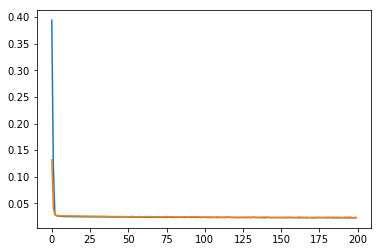

In [300]:
plot_loss(rnn_history, 'rnn_loss')

## CNN-LSTM

In [290]:
from keras.layers import TimeDistributed

def apply_CNN_LSTM(X, y, validation_data, n_in, hidden_nodes, epochs, optimizer, loss_fct):
    # reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
    X = X.reshape((X.shape[0], 2, 2, 1))
    X_val = validation_data[0].reshape((validation_data[0].shape[0], 2, 2, 1))
    y_val = validation_data[1]

    # define model
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=32, kernel_size=1, activation='relu'), input_shape=(None, 2, 1)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(hidden_nodes, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss=loss_fct, metrics=['mae'])
    model.summary()
    
    # simple early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

    # fit model
    history = model.fit(X, y, epochs=epochs, verbose=0, validation_data=(X_val, y_val), callbacks=[es])
    train_score = model.evaluate(X, y, verbose=0)
    score = model.evaluate(X_val, y_val, verbose=1)
    predictions = model.predict(X_val)
    
    print('The mse train loss is: ', train_score[0])
    print('The mae train loss is: ', train_score[1])
    print('The mse test loss is: ', score[0])
    print('The mae test loss is: ', score[1])
    
    return history, score, predictions


In [291]:
# parameters
n_in = 4
epochs = 500
hidden_nodes = 50
loss_fct = 'mse'
optimizer = 'Adam'
train_val_split = int(0.8*len(example_spread))

In [292]:
# prepare data
forecasting_data = series_to_supervised(list(example_spread), example_spread.index, n_in, 1, dropnan=True)

# define dataset
X_series = forecasting_data.drop(columns='var1(t)')
y_series = forecasting_data['var1(t)']
X = np.asarray(forecasting_data.drop(columns='var1(t)').values)
y = np.asarray(forecasting_data[['var1(t)']].values)

# split
X_series_train = X_series[:train_val_split]
X_series_val= X_series[train_val_split:]
y_series_train = y_series[:train_val_split]
y_series_val = y_series[train_val_split:]

X_train = X[:train_val_split]
X_val = X[train_val_split:]
y_train = y[:train_val_split]
y_val = y[train_val_split:]

In [293]:
cnn_lstm_history, cnn_lstm_score, cnn_lstm_predictions = apply_CNN_LSTM(X_train, y_train, (X_val, y_val), n_in,
                                                                        hidden_nodes, epochs, optimizer, loss_fct)
cnn_lstm_predictions = pd.Series(data=cnn_lstm_predictions.flatten(), index=y_series_val.index)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_28 (TimeDis (None, None, 2, 32)       64        
_________________________________________________________________
time_distributed_29 (TimeDis (None, None, 1, 32)       0         
_________________________________________________________________
time_distributed_30 (TimeDis (None, None, 32)          0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 50)                16600     
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 51        
Total params: 16,715
Trainable params: 16,715
Non-trainable params: 0
_________________________________________________________________
Epoch 00082: early stopping
399/399 [==============================] - 0s 54us/step
The mse train loss is:  0.02208408942411405
The mae tr

The mse test loss is:  0.03279840758999338
The mae test loss is:  0.12959755337178558


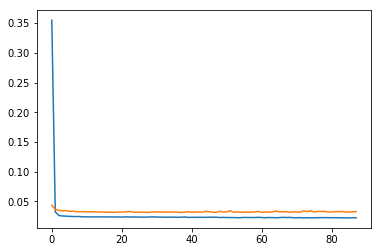

In [289]:
plot_loss(cnn_lstm_history, 'cnn_lstm_loss')

The mse test loss is:  0.0323833463092645
The mae test loss is:  0.12981718834629632


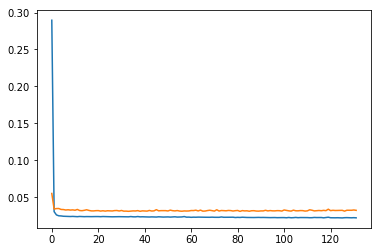

In [284]:
print('The mse test loss is: ', cnn_lstm_score[0])
print('The mae test loss is: ', cnn_lstm_score[1])
plot_loss(cnn_lstm_history, 'cnn_lstm_loss')

**Predictions**

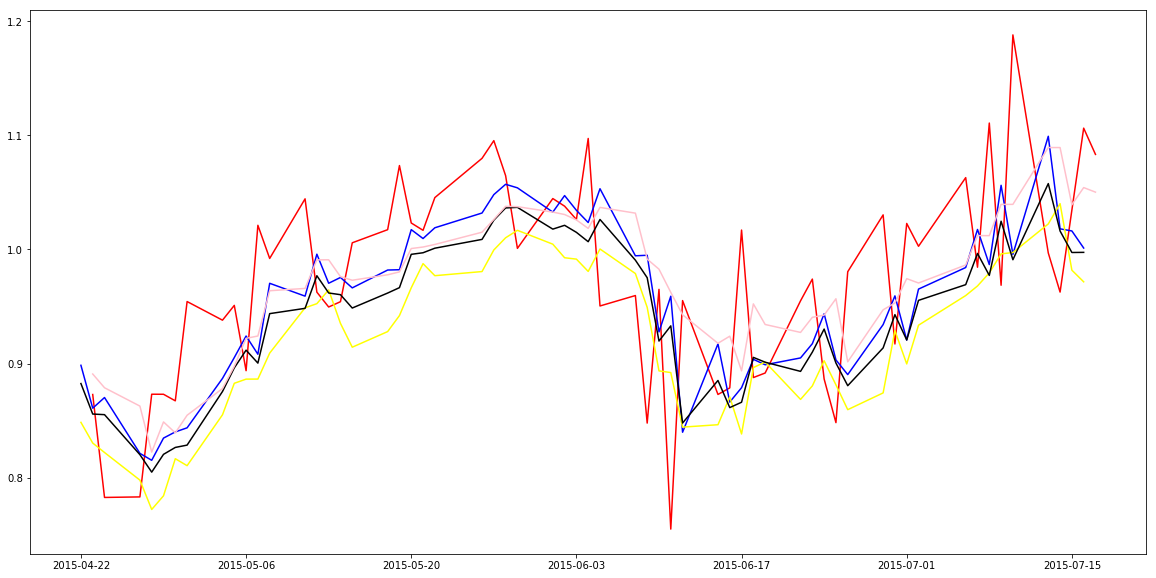

In [244]:
# Rerun y_test!

plt.close()
plt.figure(figsize=(20,10))
plt.plot(y_series_val[:60], color='red')
plt.plot(mlp_predictions[:60], color='blue')
plt.plot(cnn_predictions[:60], color='yellow')
plt.plot(rnn_predictions[:60], color='black')
plt.plot(cnn_lstm_predictions[:60], color='pink')
plt.show()

## Encoder-Decoder LSTM Multi-step Forecasting

In [55]:
from keras.layers import RepeatVector

def apply_LSTM_multistep(X, y, validation_data, n_in, hidden_nodes, epochs, optimizer, loss_fct):
    # reshape from [samples, timesteps] into [samples, timesteps, features]
    X = X.reshape((X.shape[0], X.shape[1], 1))
    y = y.reshape((y.shape[0], y.shape[1], 1))
    X_val = validation_data[0].reshape((validation_data[0].shape[0], validation_data[0].shape[1], 1))
    y_val = validation_data[1].reshape((validation_data[1].shape[0], validation_data[1].shape[1], 1))

    # define model
    model = Sequential()
    model.add(LSTM(hidden_nodes, activation='relu', input_shape=(n_in, 1)))
    model.add(RepeatVector(2))
    model.add(LSTM(hidden_nodes, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(1)))
    model.compile(optimizer=optimizer, loss=loss_fct)
    model.summary()

    # fit model
    history = model.fit(X, y, epochs=epochs, verbose=0, validation_data=(X_val, y_val))
    score = model.evaluate(X_val, y_val, verbose=1)
    predictions = model.predict(X_val)
    
    return history, score, predictions


In [56]:
# parameters
n_in = 5
n_out = 2
epochs = 200
hidden_nodes = 20
loss_fct = 'mse'
optimizer = 'Adam'

In [97]:
# prepare data
forecasting_data = series_to_supervised(list(example_spread), example_spread.index, n_in, n_out)

# define dataset
X_series = forecasting_data.drop(columns=['var1(t)','var1(t+1)'])
y_series = forecasting_data['var1(t)', 'var1(t+1)']
X = np.asarray(forecasting_data.drop(columns=['var1(t)','var1(t+1)']).values)
y = np.asarray(forecasting_data[['var1(t)', 'var1(t+1)']].values)

# split
X_series_train = X_series[:int(0.66*len(X))]
X_series_val= X_series[int(0.66*len(X)):]
y_series_train = y_series[:int(0.66*len(X))]
y_series_val = y_series[int(0.66*len(X)):]

X_train = X[:int(0.66*len(X))]
X_val = X[int(0.66*len(X)):]
y_train = y[:int(0.66*len(y))]
y_val = y[int(0.66*len(y)):]

In [58]:
lstm_multistep_history, lstm_multistep_score, lstm_multistep_predictions = \
    apply_LSTM_multistep(X_train, y_train, (X_val, y_val), n_in, hidden_nodes, epochs, optimizer, loss_fct)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 20)                1760      
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 2, 20)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 2, 20)             3280      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 2, 1)              21        
Total params: 5,061
Trainable params: 5,061
Non-trainable params: 0
_________________________________________________________________
683/683 [==============================] - 0s 69us/step


The test loss is:  0.028962554742812587


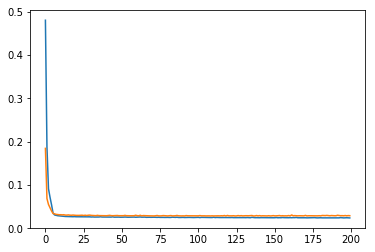

In [59]:
print('The test loss is: ', lstm_multistep_score)
plot_loss(lstm_multistep_history, 'lstm_multistep_loss')

**Studying which variable is more meaningful when predicting the pnl**

From the table below, we can see that the spread change is way more indicative of the pnl (corr = 1), because everytime the spread changes the pnl changes the same way. On the other hand, returns simply by itself do not predict the pnl, because the value of X and Y still influence the outcome.

In [301]:
pairs[5]
pairs[5][2]
df = pd.DataFrame(data={'X_test':pairs[0][2]['X_test'], 'Y_test':pairs[0][2]['Y_test']})
# alternative 1
x_returns = -(pairs[0][2]['coint_coef'])*(df.X_test-df.X_test.shift(1))/df.X_test.shift(1)
y_returns = (df.Y_test-df.Y_test.shift(1))/df.Y_test.shift(1)
dunis_returns = x_returns + y_returns
df['dunis_returns/pnl']=dunis_returns
# alternative 2
spread = df.Y_test-(pairs[0][2]['coint_coef'])*df.X_test
spread_pct_change = (spread-spread.shift(1))/abs(spread.shift(1))
df['spread_pct_change'] = spread_pct_change
df['spread']=spread
# with normalized data
normalized_spread = (spread - spread.mean())/np.std(spread)
normalized_spread_pct_change = normalized_spread.pct_change()
#df['normalized_spread']=normalized_spread
df['normalized_spread_pct_change']=normalized_spread_pct_change
# other
df['pnl'] = df.X_test.shift(periods=1)*x_returns + df.Y_test.shift(periods=1)*y_returns
# regular returns
df['ret'] = df.pnl/(np.abs(df.X_test.shift(periods=1)*(pairs[0][2]['coint_coef']))+np.abs(df.Y_test.shift(periods=1)))
df

,X_test,Y_test,dunis_returns/pnl,spread_pct_change,spread,normalized_spread_pct_change,pnl,ret
2018-01-02,10.024570,21.0400,NaN,NaN,7.973652,NaN,NaN,NaN
2018-01-03,10.240998,21.3200,-0.014833,-0.000263,7.971552,0.003465,-0.002100,-0.000062
2018-01-04,10.260674,21.3900,0.000779,0.005564,8.015907,-0.072951,0.044355,0.001279
2018-01-05,10.211485,21.3800,0.005781,0.006751,8.070020,-0.096005,0.054114,0.001557
2018-01-08,10.270511,21.4900,-0.002389,0.004097,8.103084,-0.064889,0.033064,0.000953
2018-01-09,10.447589,21.7500,-0.010374,0.003602,8.132275,-0.061265,0.029191,0.000837
2018-01-10,10.516453,21.8700,-0.003074,0.003719,8.162516,-0.067610,0.030241,0.000855
2018-01-11,10.536128,21.9500,0.001219,0.006659,8.216871,-0.130333,0.054355,0.001528
2018-01-12,10.683693,22.1400,-0.009599,-0.000285,8.214530,0.006454,-0.002341,-0.000066
2018-01-16,10.595154,22.0300,0.005834,0.000658,8.219934,-0.014805,0.005404,0.000150


In [302]:
df.pnl.corr(df.spread_pct_change)

0.9946504653335959

In [303]:
df.spread_pct_change.corr(df.ret)

0.9997079157457316

In [259]:
df.normalized_spread_pct_change.corr(df.ret)

0.0388750160893099

It thus make totally sense to predict the spread percentage change, assuming we buy the stock at its current price. However, if we consider we always put 1$ on each side of the trade, the scenario shifts.

In [309]:
pairs[5]
pairs[5][2]
df = pd.DataFrame(data={'X_test':pairs[0][2]['X_train'][train_val_split:],
                        'Y_test':pairs[0][2]['Y_train'][train_val_split:]})
# alternative 1
x_returns = -(pairs[0][2]['coint_coef'])*(df.X_test-df.X_test.shift(1))/df.X_test.shift(1)
y_returns = (df.Y_test-df.Y_test.shift(1))/df.Y_test.shift(1)
dunis_returns = x_returns + y_returns
df['dunis_returns/pnl']=dunis_returns
# alternative 2
spread = df.Y_test-(pairs[0][2]['coint_coef'])*df.X_test
spread_pct_change = (spread-spread.shift(1))/abs(spread.shift(1))
df['spread_pct_change'] = spread_pct_change
df['spread']=spread
# with normalized data
normalized_spread = (spread - spread.mean())/np.std(spread)
normalized_spread_pct_change = normalized_spread.pct_change()
#df['normalized_spread']=normalized_spread
df['normalized_spread_pct_change']=normalized_spread_pct_change
# other
df['pnl'] = df.X_test.shift(periods=1)*x_returns + df.Y_test.shift(periods=1)*y_returns
# regular returns
df['ret'] = df.pnl/(np.abs(df.X_test.shift(periods=1)*(pairs[0][2]['coint_coef']))+np.abs(df.Y_test.shift(periods=1)))
df

,X_test,Y_test,dunis_returns/pnl,spread_pct_change,spread,normalized_spread_pct_change,pnl,ret
2015-04-15,14.372813,26.7300,NaN,NaN,7.996011,NaN,NaN,NaN
2015-04-16,14.549891,27.0800,-0.002965,0.014906,8.115202,0.109258,0.119191,0.002622
2015-04-17,14.490865,26.9300,-0.000251,-0.009003,8.042139,-0.060378,-0.073064,-0.001587
2015-04-20,14.589242,27.1100,-0.002165,0.006438,8.093912,0.045533,0.051773,0.001130
2015-04-21,14.412164,26.7500,0.002541,-0.015962,7.964720,-0.108672,-0.129191,-0.002801
2015-04-22,14.500703,26.8000,-0.006138,-0.008212,7.899316,-0.061724,-0.065404,-0.001436
2015-04-23,14.687618,27.2800,0.001109,0.029923,8.135684,0.237743,0.236368,0.005172
2015-04-24,14.736806,27.3100,-0.003265,-0.004193,8.101571,-0.027721,-0.034114,-0.000735
2015-04-27,14.648268,27.1300,0.001240,-0.007973,8.036975,-0.053988,-0.064596,-0.001389
2015-04-28,14.638430,27.0700,-0.001336,-0.005870,7.989798,-0.041680,-0.047177,-0.001021


In [310]:
df.spread_pct_change.corr(df.ret)

0.989613730214564